In [45]:
# import basic libraries
# reused old code from hw1 for logistic regression
import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy import sparse
import scipy
%matplotlib inline

In [46]:
# simple sigmoid
def sigmoid(x, thetas):
    return 1.0 / (1.0 + np.exp(-(x @ thetas)))

In [47]:
# negative log likelihood
def neg_log_likelihood(X,y, thetas, alpha=1000):
    sig = sigmoid(X,thetas)
    llhood = np.sum(y * np.log(sig)) + np.sum((1-y)* np.log(1-sig))
    reg = alpha * (thetas.T @ thetas)/2
    return -llhood + reg

In [48]:
# positive log likelihood
def log_likelihood(X,y, thetas, alpha=1000):
    sig = sigmoid(X,thetas)
    llhood = np.sum(y * np.log(sig)) + np.sum((1-y)* np.log(1-sig))
    reg = alpha * (thetas.T @ thetas)/2
    return llhood + reg

In [49]:
# gradient of the log likelihood, regularized
def grad_llhood(X, y, thetas, alpha=1000):
    val = X.T @ ( sigmoid(X,thetas) -y ) + alpha * thetas
    return val

In [50]:
def hess_log_likelihood(X, thetas, alpha=1000):
    mu = sigmoid(X, thetas)
    return X.T @ sparse.diags(mu * (1 - mu)) @ X + alpha * sparse.eye(X.shape[1])

In [51]:
def newtonStep(X, y, thetas, alpha = 1000):
    return scipy.linalg.cho_solve(
        scipy.linalg.cho_factor(hess_log_likelihood(X, thetas, alpha=alpha)),
        grad_llhood(X, y, thetas, alpha=alpha),
    )

In [52]:
def newton(X, y, alpha=1000, tol=1e-6, max_iters=300):
    y = y.astype(bool)
    thetas = np.zeros(X.shape[1])
    objective = [log_likelihood(X, y, thetas, alpha)]
    step = newtonStep(X, y, thetas, alpha=alpha)
    
    while len(objective)-1 <= max_iters and np.linalg.norm(step) > tol:
        step = newtonStep(X, y, thetas, alpha=alpha)
        thetas = thetas - step
        objective.append(log_likelihood(X, y, thetas, alpha))
    return thetas, objective

In [53]:
def gradient_desc(X,y, alp=1000, max_iters=10, tol=1e-6):
    
    thetas = np.zeros((xTrain.shape[1],1)) # should be the same shape as the number of features
    outputs = [log_likelihood(X,y, thetas, alp)] # store the log_likelihood values
    gradient = grad_llhood(X, y, thetas, alp) # takes the gradient of the likelihood for descent
    
    while len(outputs)-1  <= max_iters and np.linalg.norm(gradient) > tol:
        gradient = grad_llhood(X, y, thetas, alp)
        thetas = thetas - 1e-9 * gradient
        outputs.append(neg_log_likelihood(X, y, thetas, alp))
    return thetas, outputs

In [54]:
def sample_posterior(X, thetas, S=5000, alpha=1000):
    H = hess_log_likelihood(X, thetas, alpha=alpha)
    thetas = np.random.multivariate_normal(thetas, np.linalg.inv(H), S)
    return H, thetas

In [55]:
def predict(X, thetas, S=5000, alpha=1000):
    H, thetas = sample_posterior(X, thetas, S=S, alpha=alpha)
    return sigmoid(X, thetas.T).mean(axis=1)

In [56]:
def line(thetas, x0, xf):
    x = np.array([x0, xf])
    plt.plot(x, -(thetas[1]*x + thetas[0])/thetas[2], alpha=0.3, color="cyan")

In [57]:
X = np.loadtxt("classification.csv", delimiter=",")
print(pd.read_csv("classification.csv", delimiter=",").head())
y = X[:, 2]
X = np.hstack((np.ones((X.shape[0],1)), X[:, :2]))

   # hours_studied  grade_in_class  pass_exam
0         0.882026        0.200079          0
1         0.489369        1.120447          0
2         0.933779       -0.488639          0
3         0.475044       -0.075679          0
4        -0.051609        0.205299          0


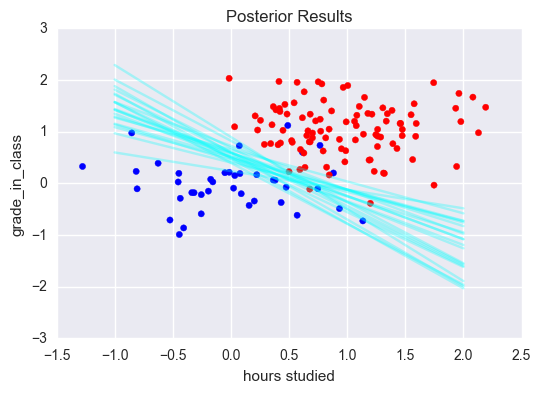

In [58]:
alpha = 1
thetas, cost = newton(X, y, alpha=1)

np.random.seed(0)
H, thets = sample_posterior(X, thetas, S=20, alpha=1)
for factor in thets:
    line(factor, -1.0, 2.0)
    
plt.scatter(X[:, 1], # hours studied
            X[:, 2], # grade in the class
            color = ["red" if y_ ==1 else "blue" for y_ in y])
plt.xlabel("hours studied")
plt.ylabel("grade_in_class")
plt.title("Posterior Results")

(10000,)


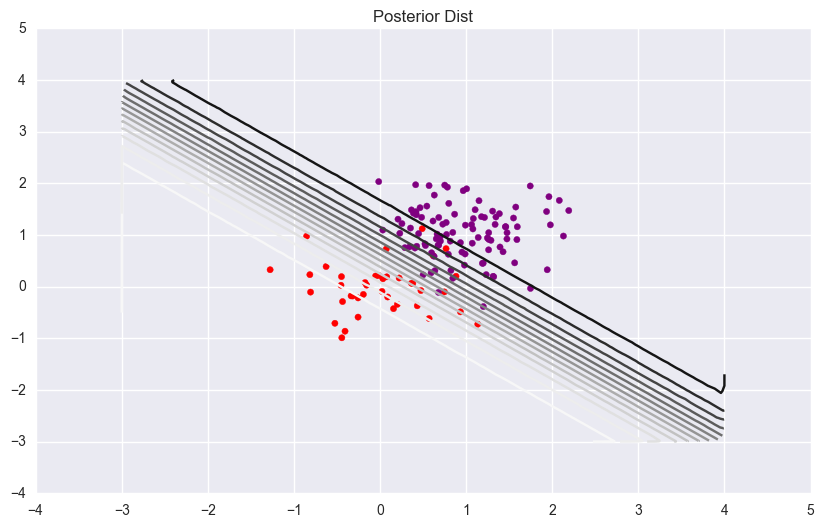

In [59]:
plt.figure(figsize=(10,6))
np.random.seed(24)
N = 10000
X_next = 7*np.random.rand(N,2) - 3
X_bias = np.hstack((np.ones((X_next.shape[0],1)),X_next))
y_next = predict(X_bias, thetas, S=200, alpha=1)

print(y_next.shape)
levels = np.linspace(y_next.min(), y_next.max(), 15)

plt.tricontour(X_next[:,0], X_next[:,1], y_next, levels=levels)
plt.scatter(X[:,1], X[:,2],color=["purple" if y_next==1. else "red" for y_next in y],)
plt.title("Posterior Dist")

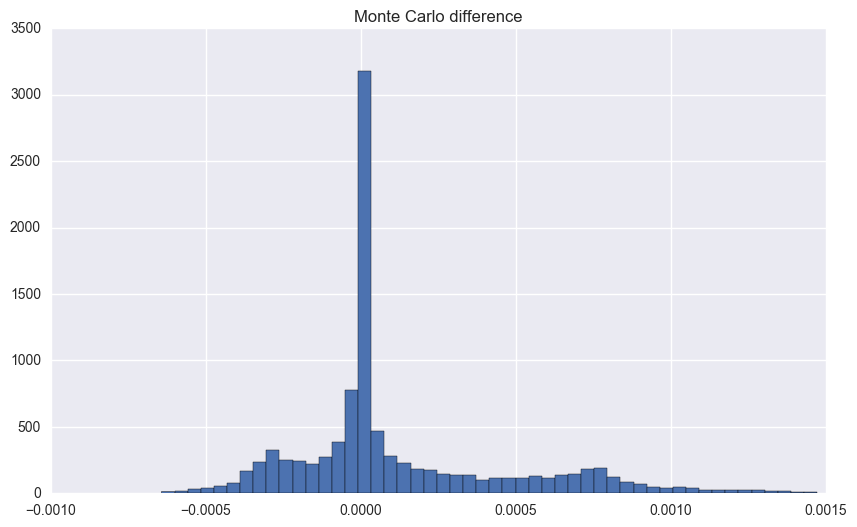

In [60]:
plt.figure(figsize=(10,6))
plt.title("Monte Carlo difference")
_ = plt.hist(sigmoid(X_bias, thetas) - y_next, bins=50)